In [157]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [158]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [159]:
tf.keras.backend.clear_session()

In [160]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [161]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [162]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [163]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


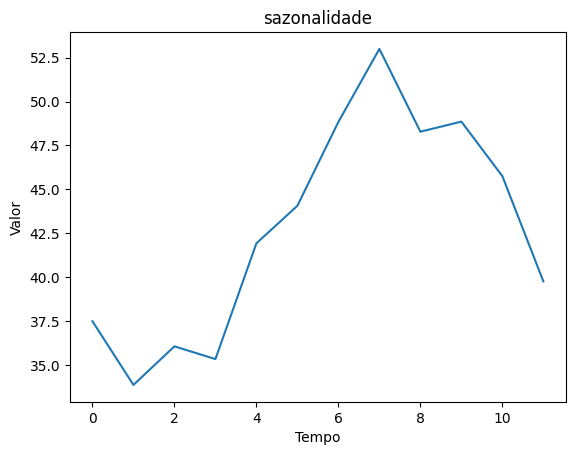

,sazonalidade
sazonalidade,
0,37.484568
1,33.856379
2,36.053154
3,35.327587
4,41.923759
5,44.063440
6,48.840487
7,52.998027
8,48.282743


In [164]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [165]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568,13.867
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379,10.777
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154,13.888
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587,11.859
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.923759,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.063440,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.840487,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.998027,NaN


In [166]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 249, dtype: float64

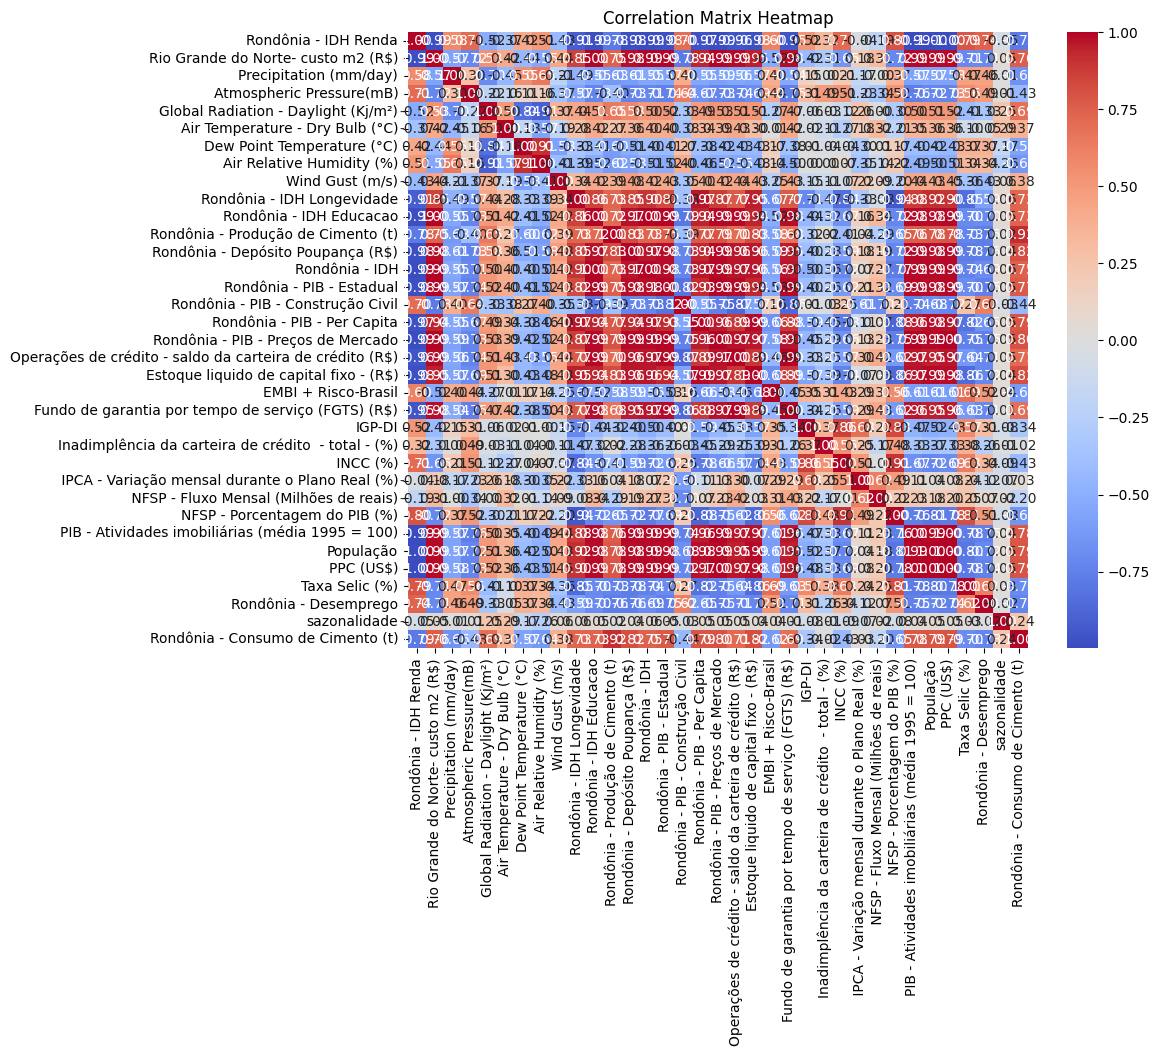

In [167]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [168]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [169]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rondônia - IDH Renda,2.782344e+04
1,Rio Grande do Norte- custo m2 (R$),1.573977e+05
2,Precipitation (mm/day),5.151489e+00
3,Atmospheric Pressure(mB),4.029496e+01
4,Global Radiation - Daylight (Kj/m²),1.950882e+01
5,Air Temperature - Dry Bulb (°C),7.481777e+02
6,Dew Point Temperature (°C),2.545420e+03
7,Air Relative Humidity (%),4.079294e+03
8,Wind Gust (m/s),8.859568e+00
9,Rondônia - IDH Longevidade,1.314046e+06


In [170]:
# data =data.drop(['Rondônia - IDH Educacao',
#                  'IGP-DI', 
#                  'Rondônia - IDH',
#                  'Inadimplência da carteira de crédito  - total - (%)',
#                  ' INCC (%)',
#                  'População',
#                  'PIB - Atividades imobiliárias (média 1995 = 100)',
#                  'Operações de crédito - saldo da carteira de crédito (R$)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 3


,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,4.987000,5.714165e+05,0.688843,2.068350e+07,1.587672e+06,11.468162,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568
1,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,4.987000,5.760053e+05,0.689031,2.071062e+07,1.589518e+06,11.472453,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379
2,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,4.987000,5.805941e+05,0.689218,2.073774e+07,1.591364e+06,11.476744,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154
3,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,4.987000,5.851830e+05,0.689405,2.076486e+07,1.593210e+06,11.481034,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587
4,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,4.987000,5.897718e+05,0.689592,2.079198e+07,1.595056e+06,11.485325,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,20182.842138,2.387423,996.715817,1383.894695,27.834185,21.667735,72.319505,1.372388,0.756336,22.332591,1.837920e+06,0.712570,2.498975e+07,1.456818e+06,11.801901,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,7.648181,52.998027
152,20277.786620,2.669846,996.683684,1400.376268,27.625174,21.986665,74.214453,1.347968,0.756917,22.039848,1.832067e+06,0.713038,2.500687e+07,1.455461e+06,11.803874,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,7.647280,48.282743
153,20370.142537,2.849432,995.700696,1387.557616,27.474897,22.274156,75.852896,1.370837,0.757498,21.780062,1.826214e+06,0.713506,2.502399e+07,1.454104e+06,11.805847,3.177292e+06,7.822521e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,7.646378,48.856456
154,20461.733612,2.896477,994.199493,1378.538222,27.393100,22.585594,77.371960,1.361279,0.758080,21.511017,1.820362e+06,0.713974,2.504110e+07,1.452747e+06,11.807820,3.192250e+06,7.821333e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,1.972040e+08,394.

In [171]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,0.382650,1.398274,0.058997,-0.309956,-0.599100,-0.415108,0.081587,-2.638555,-1.051001,-1.442810,-1.869000,-1.562503,0.055364,-2.308551,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,1.055035
1,0.379410,1.391727,0.060871,-0.308547,-0.599076,-0.415534,0.082875,-2.575239,-1.051001,-1.433481,-1.840046,-1.542576,0.084965,-2.262505,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,1.041760
2,0.377521,1.387908,0.061964,-0.307726,-0.599062,-0.415782,0.083627,-2.511922,-1.051001,-1.424152,-1.811092,-1.522649,0.114566,-2.216459,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,1.028485
3,0.377318,1.387498,0.062081,-0.307638,-0.599061,-0.415809,0.083707,-2.448606,-1.051001,-1.414823,-1.782138,-1.502722,0.144167,-2.170413,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,1.015210
4,0.388351,1.374940,0.051385,-0.301390,-0.577361,-0.399553,0.067659,-2.385289,-1.051001,-1.405494,-1.753184,-1.482795,0.173768,-2.124366,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,1.001935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,-1.316064,-0.173353,1.093940,2.710871,-0.813320,-1.779384,0.265952,1.231965,-0.017730,1.131960,1.800302,1.601560,-2.042917,1.273052,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123,-0.198507
152,-0.654981,-0.176474,1.207770,2.381831,-0.568594,-1.464721,0.194127,1.357095,-0.035169,1.120062,1.872677,1.614137,-2.064677,1.294224,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135,-0.200463
153,-0.234612,-0.271962,1.119238,2.145255,-0.347994,-1.192652,0.261390,1.482225,-0.050644,1.108164,1.945053,1.626714,-2.086436,1.315397,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308,-0.202419
154,-0.124492,-0.417788,1.056946,2.016484,-0.109017,-0.940406,0.233278,1.607356,-0.066671,1.096266,2.017428,1.639292,-2.108196,1.336569,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029,-0.204375


In [172]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,0.382650,1.398274,0.058997,-0.309956,-0.599100,-0.415108,0.081587,-2.638555,-1.051001,-1.442810,-1.869000,-1.562503,0.055364,-2.308551,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,1.055035
1,0.379410,1.391727,0.060871,-0.308547,-0.599076,-0.415534,0.082875,-2.575239,-1.051001,-1.433481,-1.840046,-1.542576,0.084965,-2.262505,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,1.041760
2,0.377521,1.387908,0.061964,-0.307726,-0.599062,-0.415782,0.083627,-2.511922,-1.051001,-1.424152,-1.811092,-1.522649,0.114566,-2.216459,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,1.028485
3,0.377318,1.387498,0.062081,-0.307638,-0.599061,-0.415809,0.083707,-2.448606,-1.051001,-1.414823,-1.782138,-1.502722,0.144167,-2.170413,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,1.015210
4,0.388351,1.374940,0.051385,-0.301390,-0.577361,-0.399553,0.067659,-2.385289,-1.051001,-1.405494,-1.753184,-1.482795,0.173768,-2.124366,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,1.001935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.354891,-1.045600,1.119775,0.157337,-0.853270,-0.799531,0.000914,0.443904,0.368727,1.295239,1.207952,1.426927,-1.698963,1.031465,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621,-0.516733
140,0.576029,-1.307741,0.643230,0.472113,-0.335759,-0.505821,0.071512,0.426333,0.329269,1.279240,1.225096,1.444245,-1.737291,1.050141,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121,-0.450349
141,0.521225,-1.284843,0.354868,1.511885,0.322375,-0.412129,0.337704,0.408763,0.290141,1.263242,1.242240,1.461563,-1.775618,1.068817,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902,-0.383966
142,-0.219561,-1.293683,-0.134536,2.021939,0.679084,-0.331480,0.488695,0.391193,0.251127,1.247244,1.259385,1.478881,-1.813946,1.087494,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143,-0.317582


In [173]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      21.211000
1      15.823000
2      15.195000
3      15.479000
4      18.536000
         ...    
139    43.196941
140    39.826639
141    40.236707
142    38.016415
143    32.774000
Name: Rondônia - Consumo de Cimento (t), Length: 144, dtype: float64

In [174]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [175]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 29)

In [176]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
108,0.342761,0.181930,-0.229275,-0.552937,-0.239433,0.001800,0.516682,0.779408,1.556690,0.717536,0.691623,0.750142,-0.382393,0.798503,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183,-2.588303
109,0.825641,0.206291,0.000738,-0.696164,-0.287302,0.029339,0.378472,0.773778,1.545148,0.757351,0.703867,0.774128,-0.438069,0.784227,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767,-2.521287
110,0.165219,0.254677,0.265230,-0.748196,-0.352669,-0.000402,0.241093,0.768147,1.533110,0.797167,0.716111,0.798115,-0.493745,0.769951,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482,-2.454271
111,-1.070771,0.291488,0.535327,-0.911579,-0.696938,-0.212359,0.094133,0.762517,1.532415,0.836982,0.728356,0.822101,-0.549421,0.755674,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413,-2.387255
112,-1.493288,0.329335,0.870815,-0.875418,-1.294813,-0.674353,-0.003030,0.756886,1.522987,0.876798,0.740600,0.846087,-0.605097,0.741398,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135,-2.320239
113,-1.793789,0.343275,1.127338,-0.534179,-1.572062,-1.030609,-0.001280,0.751256,1.492864,0.916613,0.752844,0.870073,-0.660773,0.727122,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280,-2.253223
114,-1.697352,0.290176,1.339005,-0.160783,-1.663375,-1.255441,0.010178,0.745626,1.456278,0.956428,0.765088,0.894060,-0.716449,0.712846,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452,-2.186207
115,-0.901934,0.215320,1.202739,0.349032,-1.404662,-1.249617,0.106857,0.739995,1.414115,0.996244,0.777333,0.918046,-0.772125,0.698570,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037,-2.119191
116,-0.976356,0.144468,0.712100,0.124038,-0.855833,-0.716302,0.109142,0.734365,1.358536,1.036059,0.789577,0.942032,-0.827801,0.684294,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721,-2.052174
117,-1.015980,-0.009133,0.477243,0.368483,-0.422603,-0.489517,-0.258987,0.728734,1.313817,1.075875,0.801821,0.966018,-0.883477,0.670018,0.876422,0.975319,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.900088,0.977769,-1.241995,-1.985158


In [177]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 29)

In [178]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [179]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.21,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [180]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [181]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1678520973, 39740464, 1684742991, 2607027576, 1364252687, 2117877766, 2915949573, 2058797264, 611371162, 2031019438]


Step: 0 ___________________________________________
val_loss: 204.58523559570312
winner_seed: 1678520973


Step: 1 ___________________________________________
val_loss: 95.95944213867188
winner_seed: 39740464


Step: 2 ___________________________________________
val_loss: 451.3398132324219


Step: 3 ___________________________________________
val_loss: 208.9547119140625


Step: 4 ___________________________________________
val_loss: 542.6277465820312


Step: 5 ___________________________________________
val_loss: 579.8809814453125


Step: 6 ___________________________________________
val_loss: 270.9045104980469


Step: 7 ___________________________________________
val_loss: 91.76412963867188
winner_seed: 2058797264


Step: 8 ___________________________________________
val_loss: 206.1482696533203


Step: 9 ___________________________________________
val_loss: 544.60028

In [182]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
3/3 [==============================] - 2s 174ms/step - loss: 3822.6052 - val_loss: 182.7941
Epoch 2/10000
3/3 [==============================] - 0s 12ms/step - loss: 471.3252 - val_loss: 1196.6407
Epoch 3/10000
3/3 [==============================] - 0s 11ms/step - loss: 481.9166 - val_loss: 438.6400
Epoch 4/10000
3/3 [==============================] - 0s 11ms/step - loss: 485.5386 - val_loss: 226.5813
Epoch 5/10000
3/3 [==============================] - 0s 12ms/step - loss: 1040.1802 - val_loss: 758.1114
Epoch 6/10000
3/3 [==============================] - 0s 12ms/step - loss: 867.8427 - val_loss: 1296.4373
Epoch 7/10000
3/3 [==============================] - 0s 12ms/step - loss: 1292.3845 - val_loss: 690.6832
Epoch 8/10000
3/3 [==============================] - 0s 11ms/step - loss: 771.0699 - val_loss: 753.7735
Epoch 9/10000
3/3 [==============================] - 0s 11ms/step - loss: 664.9310 - val_loss: 663.9434
Epoch 10/10000
3/3 [==============================] - 0s 1

3/3 [==============================] - 0s 11ms/step - loss: 505.5574 - val_loss: 497.8330
Epoch 80/10000
3/3 [==============================] - 0s 10ms/step - loss: 564.7191 - val_loss: 596.7291
Epoch 81/10000
3/3 [==============================] - 0s 10ms/step - loss: 508.0797 - val_loss: 578.0044
Epoch 82/10000
3/3 [==============================] - 0s 11ms/step - loss: 512.4453 - val_loss: 588.4709
Epoch 83/10000
3/3 [==============================] - 0s 11ms/step - loss: 502.4865 - val_loss: 626.0905
Epoch 84/10000
3/3 [==============================] - 0s 11ms/step - loss: 534.1163 - val_loss: 507.0396
Epoch 85/10000
3/3 [==============================] - 0s 11ms/step - loss: 518.4763 - val_loss: 483.6169
Epoch 86/10000
3/3 [==============================] - 0s 12ms/step - loss: 599.4301 - val_loss: 807.8547
Epoch 87/10000
3/3 [==============================] - 0s 11ms/step - loss: 529.2115 - val_loss: 618.4003
Epoch 88/10000
3/3 [==============================] - 0s 11ms/step - l

3/3 [==============================] - 0s 10ms/step - loss: 460.4008 - val_loss: 438.8188
Epoch 157/10000
3/3 [==============================] - 0s 10ms/step - loss: 481.2781 - val_loss: 725.7944
Epoch 158/10000
3/3 [==============================] - 0s 10ms/step - loss: 510.6885 - val_loss: 461.1265
Epoch 159/10000
3/3 [==============================] - 0s 10ms/step - loss: 518.7443 - val_loss: 505.7382
Epoch 160/10000
3/3 [==============================] - 0s 11ms/step - loss: 457.2715 - val_loss: 455.8926
Epoch 161/10000
3/3 [==============================] - 0s 11ms/step - loss: 465.4730 - val_loss: 474.0281
Epoch 162/10000
3/3 [==============================] - 0s 10ms/step - loss: 458.0327 - val_loss: 450.4707
Epoch 163/10000
3/3 [==============================] - 0s 10ms/step - loss: 450.2174 - val_loss: 468.0646
Epoch 164/10000
3/3 [==============================] - 0s 11ms/step - loss: 462.5176 - val_loss: 550.0309
Epoch 165/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 432.7159 - val_loss: 445.0639
Epoch 234/10000
3/3 [==============================] - 0s 11ms/step - loss: 437.8768 - val_loss: 485.0357
Epoch 235/10000
3/3 [==============================] - 0s 11ms/step - loss: 441.4341 - val_loss: 414.6527
Epoch 236/10000
3/3 [==============================] - 0s 10ms/step - loss: 449.8184 - val_loss: 470.2264
Epoch 237/10000
3/3 [==============================] - 0s 11ms/step - loss: 440.3301 - val_loss: 414.2080
Epoch 238/10000
3/3 [==============================] - 0s 11ms/step - loss: 437.7585 - val_loss: 422.4630
Epoch 239/10000
3/3 [==============================] - 0s 10ms/step - loss: 432.0419 - val_loss: 474.8861
Epoch 240/10000
3/3 [==============================] - 0s 11ms/step - loss: 436.0325 - val_loss: 506.3524
Epoch 241/10000
3/3 [==============================] - 0s 11ms/step - loss: 454.0269 - val_loss: 413.8881
Epoch 242/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 10ms/step - loss: 413.4330 - val_loss: 400.9015
Epoch 311/10000
3/3 [==============================] - 0s 11ms/step - loss: 417.0259 - val_loss: 448.3339
Epoch 312/10000
3/3 [==============================] - 0s 12ms/step - loss: 413.4307 - val_loss: 397.1012
Epoch 313/10000
3/3 [==============================] - 0s 12ms/step - loss: 428.2047 - val_loss: 410.4467
Epoch 314/10000
3/3 [==============================] - 0s 11ms/step - loss: 413.9156 - val_loss: 399.6234
Epoch 315/10000
3/3 [==============================] - 0s 11ms/step - loss: 412.8127 - val_loss: 396.6273
Epoch 316/10000
3/3 [==============================] - 0s 11ms/step - loss: 409.0471 - val_loss: 413.7675
Epoch 317/10000
3/3 [==============================] - 0s 10ms/step - loss: 410.7863 - val_loss: 404.6799
Epoch 318/10000
3/3 [==============================] - 0s 11ms/step - loss: 414.3432 - val_loss: 397.3196
Epoch 319/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 10ms/step - loss: 399.3044 - val_loss: 383.4757
Epoch 388/10000
3/3 [==============================] - 0s 10ms/step - loss: 390.9348 - val_loss: 381.6965
Epoch 389/10000
3/3 [==============================] - 0s 11ms/step - loss: 388.1283 - val_loss: 382.7412
Epoch 390/10000
3/3 [==============================] - 0s 10ms/step - loss: 397.0702 - val_loss: 382.0057
Epoch 391/10000
3/3 [==============================] - 0s 11ms/step - loss: 394.1924 - val_loss: 385.9591
Epoch 392/10000
3/3 [==============================] - 0s 11ms/step - loss: 395.6515 - val_loss: 382.8406
Epoch 393/10000
3/3 [==============================] - 0s 12ms/step - loss: 399.0164 - val_loss: 382.6697
Epoch 394/10000
3/3 [==============================] - 0s 11ms/step - loss: 391.3026 - val_loss: 386.5968
Epoch 395/10000
3/3 [==============================] - 0s 11ms/step - loss: 389.8231 - val_loss: 389.5413
Epoch 396/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 14ms/step - loss: 391.7342 - val_loss: 367.9422
Epoch 465/10000
3/3 [==============================] - 0s 12ms/step - loss: 376.3523 - val_loss: 375.1033
Epoch 466/10000
3/3 [==============================] - 0s 11ms/step - loss: 375.8902 - val_loss: 369.6510
Epoch 467/10000
3/3 [==============================] - 0s 11ms/step - loss: 368.0167 - val_loss: 369.2634
Epoch 468/10000
3/3 [==============================] - 0s 12ms/step - loss: 377.2701 - val_loss: 370.2749
Epoch 469/10000
3/3 [==============================] - 0s 12ms/step - loss: 374.7486 - val_loss: 363.7812
Epoch 470/10000
3/3 [==============================] - 0s 10ms/step - loss: 371.4785 - val_loss: 364.5938
Epoch 471/10000
3/3 [==============================] - 0s 11ms/step - loss: 371.9078 - val_loss: 367.5895
Epoch 472/10000
3/3 [==============================] - 0s 11ms/step - loss: 367.5355 - val_loss: 363.5569
Epoch 473/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 356.0683 - val_loss: 354.2648
Epoch 542/10000
3/3 [==============================] - 0s 12ms/step - loss: 364.3672 - val_loss: 352.2688
Epoch 543/10000
3/3 [==============================] - 0s 11ms/step - loss: 357.0920 - val_loss: 351.6141
Epoch 544/10000
3/3 [==============================] - 0s 11ms/step - loss: 352.6824 - val_loss: 357.5051
Epoch 545/10000
3/3 [==============================] - 0s 11ms/step - loss: 355.5674 - val_loss: 353.8878
Epoch 546/10000
3/3 [==============================] - 0s 11ms/step - loss: 355.3432 - val_loss: 370.1537
Epoch 547/10000
3/3 [==============================] - 0s 12ms/step - loss: 363.0735 - val_loss: 349.4917
Epoch 548/10000
3/3 [==============================] - 0s 11ms/step - loss: 351.1730 - val_loss: 364.9527
Epoch 549/10000
3/3 [==============================] - 0s 12ms/step - loss: 357.0640 - val_loss: 359.9129
Epoch 550/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 12ms/step - loss: 340.4516 - val_loss: 336.1142
Epoch 619/10000
3/3 [==============================] - 0s 12ms/step - loss: 340.4447 - val_loss: 337.6660
Epoch 620/10000
3/3 [==============================] - 0s 12ms/step - loss: 342.1686 - val_loss: 344.3757
Epoch 621/10000
3/3 [==============================] - 0s 11ms/step - loss: 336.2973 - val_loss: 338.1648
Epoch 622/10000
3/3 [==============================] - 0s 11ms/step - loss: 340.7128 - val_loss: 339.6264
Epoch 623/10000
3/3 [==============================] - 0s 11ms/step - loss: 339.1642 - val_loss: 350.7451
Epoch 624/10000
3/3 [==============================] - 0s 10ms/step - loss: 339.9446 - val_loss: 340.2272
Epoch 625/10000
3/3 [==============================] - 0s 11ms/step - loss: 339.7832 - val_loss: 364.2641
Epoch 626/10000
3/3 [==============================] - 0s 12ms/step - loss: 350.9232 - val_loss: 348.2487
Epoch 627/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 324.8696 - val_loss: 329.8577
Epoch 696/10000
3/3 [==============================] - 0s 12ms/step - loss: 325.6025 - val_loss: 322.9289
Epoch 697/10000
3/3 [==============================] - 0s 11ms/step - loss: 320.9915 - val_loss: 323.7269
Epoch 698/10000
3/3 [==============================] - 0s 11ms/step - loss: 318.2983 - val_loss: 323.6276
Epoch 699/10000
3/3 [==============================] - 0s 11ms/step - loss: 323.1672 - val_loss: 325.4470
Epoch 700/10000
3/3 [==============================] - 0s 11ms/step - loss: 321.0209 - val_loss: 321.4458
Epoch 701/10000
3/3 [==============================] - 0s 11ms/step - loss: 324.7902 - val_loss: 323.3010
Epoch 702/10000
3/3 [==============================] - 0s 12ms/step - loss: 323.8627 - val_loss: 325.7329
Epoch 703/10000
3/3 [==============================] - 0s 11ms/step - loss: 321.5226 - val_loss: 322.3761
Epoch 704/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 309.4292 - val_loss: 316.2415
Epoch 773/10000
3/3 [==============================] - 0s 12ms/step - loss: 327.0683 - val_loss: 313.4355
Epoch 774/10000
3/3 [==============================] - 0s 13ms/step - loss: 310.9220 - val_loss: 310.1788
Epoch 775/10000
3/3 [==============================] - 0s 11ms/step - loss: 305.4568 - val_loss: 310.3310
Epoch 776/10000
3/3 [==============================] - 0s 11ms/step - loss: 307.7497 - val_loss: 321.3917
Epoch 777/10000
3/3 [==============================] - 0s 11ms/step - loss: 309.8761 - val_loss: 320.4299
Epoch 778/10000
3/3 [==============================] - 0s 11ms/step - loss: 309.7726 - val_loss: 317.3975
Epoch 779/10000
3/3 [==============================] - 0s 11ms/step - loss: 304.4001 - val_loss: 314.8041
Epoch 780/10000
3/3 [==============================] - 0s 11ms/step - loss: 308.0068 - val_loss: 312.5629
Epoch 781/10000
3/3 [==============================] - 0s 10ms

3/3 [==============================] - 0s 11ms/step - loss: 291.9687 - val_loss: 300.1769
Epoch 850/10000
3/3 [==============================] - 0s 11ms/step - loss: 293.7751 - val_loss: 300.9073
Epoch 851/10000
3/3 [==============================] - 0s 14ms/step - loss: 295.0761 - val_loss: 299.7428
Epoch 852/10000
3/3 [==============================] - 0s 11ms/step - loss: 300.3215 - val_loss: 305.3399
Epoch 853/10000
3/3 [==============================] - 0s 12ms/step - loss: 295.1627 - val_loss: 319.6184
Epoch 854/10000
3/3 [==============================] - 0s 11ms/step - loss: 298.1525 - val_loss: 299.5985
Epoch 855/10000
3/3 [==============================] - 0s 11ms/step - loss: 294.2769 - val_loss: 300.5082
Epoch 856/10000
3/3 [==============================] - 0s 11ms/step - loss: 293.8834 - val_loss: 309.1798
Epoch 857/10000
3/3 [==============================] - 0s 11ms/step - loss: 298.3311 - val_loss: 297.8803
Epoch 858/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 10ms/step - loss: 281.3893 - val_loss: 294.7859
Epoch 927/10000
3/3 [==============================] - 0s 11ms/step - loss: 282.8779 - val_loss: 293.7243
Epoch 928/10000
3/3 [==============================] - 0s 12ms/step - loss: 283.4610 - val_loss: 289.6615
Epoch 929/10000
3/3 [==============================] - 0s 11ms/step - loss: 282.1690 - val_loss: 290.8656
Epoch 930/10000
3/3 [==============================] - 0s 12ms/step - loss: 276.2859 - val_loss: 291.7095
Epoch 931/10000
3/3 [==============================] - 0s 14ms/step - loss: 277.6445 - val_loss: 289.0213
Epoch 932/10000
3/3 [==============================] - 0s 13ms/step - loss: 278.7726 - val_loss: 288.6988
Epoch 933/10000
3/3 [==============================] - 0s 13ms/step - loss: 277.8531 - val_loss: 288.2422
Epoch 934/10000
3/3 [==============================] - 0s 11ms/step - loss: 279.9388 - val_loss: 287.1462
Epoch 935/10000
3/3 [==============================] - 0s 10ms

3/3 [==============================] - 0s 11ms/step - loss: 266.6459 - val_loss: 279.3246
Epoch 1004/10000
3/3 [==============================] - 0s 12ms/step - loss: 268.9489 - val_loss: 277.7748
Epoch 1005/10000
3/3 [==============================] - 0s 11ms/step - loss: 266.7609 - val_loss: 290.4337
Epoch 1006/10000
3/3 [==============================] - 0s 13ms/step - loss: 271.2176 - val_loss: 276.6174
Epoch 1007/10000
3/3 [==============================] - 0s 11ms/step - loss: 269.8952 - val_loss: 279.7332
Epoch 1008/10000
3/3 [==============================] - 0s 11ms/step - loss: 267.1699 - val_loss: 277.8871
Epoch 1009/10000
3/3 [==============================] - 0s 12ms/step - loss: 269.7401 - val_loss: 280.1595
Epoch 1010/10000
3/3 [==============================] - 0s 11ms/step - loss: 266.6351 - val_loss: 277.3748
Epoch 1011/10000
3/3 [==============================] - 0s 11ms/step - loss: 266.8589 - val_loss: 280.0279
Epoch 1012/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 257.3935 - val_loss: 265.6424
Epoch 1080/10000
3/3 [==============================] - 0s 11ms/step - loss: 252.4099 - val_loss: 266.0151
Epoch 1081/10000
3/3 [==============================] - 0s 11ms/step - loss: 258.4609 - val_loss: 268.2325
Epoch 1082/10000
3/3 [==============================] - 0s 11ms/step - loss: 255.2113 - val_loss: 270.4540
Epoch 1083/10000
3/3 [==============================] - 0s 10ms/step - loss: 253.0450 - val_loss: 282.8295
Epoch 1084/10000
3/3 [==============================] - 0s 11ms/step - loss: 256.0335 - val_loss: 270.6091
Epoch 1085/10000
3/3 [==============================] - 0s 11ms/step - loss: 255.6181 - val_loss: 267.7184
Epoch 1086/10000
3/3 [==============================] - 0s 11ms/step - loss: 251.5432 - val_loss: 268.6046
Epoch 1087/10000
3/3 [==============================] - 0s 12ms/step - loss: 252.3363 - val_loss: 268.0575
Epoch 1088/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 245.1543 - val_loss: 263.4825
Epoch 1156/10000
3/3 [==============================] - 0s 12ms/step - loss: 242.0841 - val_loss: 266.9160
Epoch 1157/10000
3/3 [==============================] - 0s 11ms/step - loss: 242.4723 - val_loss: 269.3752
Epoch 1158/10000
3/3 [==============================] - 0s 11ms/step - loss: 243.8009 - val_loss: 269.8926
Epoch 1159/10000
3/3 [==============================] - 0s 11ms/step - loss: 246.0317 - val_loss: 271.7042
Epoch 1160/10000
3/3 [==============================] - 0s 11ms/step - loss: 241.6680 - val_loss: 270.5251
Epoch 1161/10000
3/3 [==============================] - 0s 13ms/step - loss: 241.6069 - val_loss: 262.5215
Epoch 1162/10000
3/3 [==============================] - 0s 12ms/step - loss: 241.9601 - val_loss: 278.7639
Epoch 1163/10000
3/3 [==============================] - 0s 13ms/step - loss: 246.3463 - val_loss: 262.5932
Epoch 1164/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 231.0041 - val_loss: 258.3727
Epoch 1232/10000
3/3 [==============================] - 0s 11ms/step - loss: 229.2919 - val_loss: 279.7921
Epoch 1233/10000
3/3 [==============================] - 0s 12ms/step - loss: 232.8314 - val_loss: 261.7310
Epoch 1234/10000
3/3 [==============================] - 0s 11ms/step - loss: 231.6960 - val_loss: 270.0866
Epoch 1235/10000
3/3 [==============================] - 0s 13ms/step - loss: 232.9664 - val_loss: 258.3079
Epoch 1236/10000
3/3 [==============================] - 0s 11ms/step - loss: 231.6641 - val_loss: 264.4429
Epoch 1237/10000
3/3 [==============================] - 0s 11ms/step - loss: 231.5844 - val_loss: 260.7594
Epoch 1238/10000
3/3 [==============================] - 0s 11ms/step - loss: 229.6988 - val_loss: 262.9871
Epoch 1239/10000
3/3 [==============================] - 0s 11ms/step - loss: 232.6456 - val_loss: 263.8932
Epoch 1240/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 220.2562 - val_loss: 261.0412
Epoch 1308/10000
3/3 [==============================] - 0s 13ms/step - loss: 219.2676 - val_loss: 258.1915
Epoch 1309/10000
3/3 [==============================] - 0s 11ms/step - loss: 221.6576 - val_loss: 269.9571
Epoch 1310/10000
3/3 [==============================] - 0s 13ms/step - loss: 218.4082 - val_loss: 268.7403
Epoch 1311/10000
3/3 [==============================] - 0s 12ms/step - loss: 220.6025 - val_loss: 282.3069
Epoch 1312/10000
3/3 [==============================] - 0s 11ms/step - loss: 219.3454 - val_loss: 261.1786
Epoch 1313/10000
3/3 [==============================] - 0s 12ms/step - loss: 221.6053 - val_loss: 276.4370
Epoch 1314/10000
3/3 [==============================] - 0s 11ms/step - loss: 219.5647 - val_loss: 262.0629
Epoch 1315/10000
3/3 [==============================] - 0s 11ms/step - loss: 220.2604 - val_loss: 254.8513
Epoch 1316/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 207.8077 - val_loss: 259.5916
Epoch 1384/10000
3/3 [==============================] - 0s 11ms/step - loss: 209.9321 - val_loss: 255.1841
Epoch 1385/10000
3/3 [==============================] - 0s 10ms/step - loss: 211.9045 - val_loss: 261.1311
Epoch 1386/10000
3/3 [==============================] - 0s 11ms/step - loss: 212.2717 - val_loss: 268.1260
Epoch 1387/10000
3/3 [==============================] - 0s 10ms/step - loss: 208.4637 - val_loss: 257.0901
Epoch 1388/10000
3/3 [==============================] - 0s 10ms/step - loss: 209.7402 - val_loss: 259.9683
Epoch 1389/10000
3/3 [==============================] - 0s 12ms/step - loss: 211.6240 - val_loss: 256.4659
Epoch 1390/10000
3/3 [==============================] - 0s 12ms/step - loss: 211.8874 - val_loss: 254.7664
Epoch 1391/10000
3/3 [==============================] - 0s 11ms/step - loss: 208.8728 - val_loss: 256.0669
Epoch 1392/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 200.7638 - val_loss: 236.5039
Epoch 1460/10000
3/3 [==============================] - 0s 11ms/step - loss: 204.3616 - val_loss: 244.9009
Epoch 1461/10000
3/3 [==============================] - 0s 11ms/step - loss: 199.2464 - val_loss: 255.7122
Epoch 1462/10000
3/3 [==============================] - 0s 10ms/step - loss: 201.4088 - val_loss: 256.5565
Epoch 1463/10000
3/3 [==============================] - 0s 12ms/step - loss: 201.0382 - val_loss: 244.2412
Epoch 1464/10000
3/3 [==============================] - 0s 10ms/step - loss: 203.8306 - val_loss: 249.4161
Epoch 1465/10000
3/3 [==============================] - 0s 11ms/step - loss: 208.6021 - val_loss: 247.3920
Epoch 1466/10000
3/3 [==============================] - 0s 10ms/step - loss: 201.3855 - val_loss: 238.0960
Epoch 1467/10000
3/3 [==============================] - 0s 12ms/step - loss: 201.0499 - val_loss: 248.0743
Epoch 1468/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 195.5513 - val_loss: 242.1457
Epoch 1536/10000
3/3 [==============================] - 0s 12ms/step - loss: 190.6711 - val_loss: 241.7352
Epoch 1537/10000
3/3 [==============================] - 0s 11ms/step - loss: 192.3634 - val_loss: 241.1674
Epoch 1538/10000
3/3 [==============================] - 0s 11ms/step - loss: 189.8440 - val_loss: 252.7296
Epoch 1539/10000
3/3 [==============================] - 0s 11ms/step - loss: 191.1348 - val_loss: 248.5400
Epoch 1540/10000
3/3 [==============================] - 0s 11ms/step - loss: 191.1497 - val_loss: 265.6567
Epoch 1541/10000
3/3 [==============================] - 0s 12ms/step - loss: 191.4545 - val_loss: 248.6986
Epoch 1542/10000
3/3 [==============================] - 0s 13ms/step - loss: 196.6905 - val_loss: 318.3588
Epoch 1543/10000
3/3 [==============================] - 0s 11ms/step - loss: 197.1541 - val_loss: 240.8296
Epoch 1544/10000
3/3 [==============================] 

3/3 [==============================] - 0s 10ms/step - loss: 184.2001 - val_loss: 235.2050
Epoch 1612/10000
3/3 [==============================] - 0s 11ms/step - loss: 188.5910 - val_loss: 250.7793
Epoch 1613/10000
3/3 [==============================] - 0s 11ms/step - loss: 185.5457 - val_loss: 237.1256
Epoch 1614/10000
3/3 [==============================] - 0s 11ms/step - loss: 181.3901 - val_loss: 244.6849
Epoch 1615/10000
3/3 [==============================] - 0s 12ms/step - loss: 182.6652 - val_loss: 226.4929
Epoch 1616/10000
3/3 [==============================] - 0s 12ms/step - loss: 183.3305 - val_loss: 246.4827
Epoch 1617/10000
3/3 [==============================] - 0s 12ms/step - loss: 182.9444 - val_loss: 230.8295
Epoch 1618/10000
3/3 [==============================] - 0s 12ms/step - loss: 184.3009 - val_loss: 238.3407
Epoch 1619/10000
3/3 [==============================] - 0s 11ms/step - loss: 183.3144 - val_loss: 238.2373
Epoch 1620/10000
3/3 [==============================] 

3/3 [==============================] - 0s 13ms/step - loss: 174.3172 - val_loss: 219.5903
Epoch 1688/10000
3/3 [==============================] - 0s 12ms/step - loss: 173.6845 - val_loss: 231.0400
Epoch 1689/10000
3/3 [==============================] - 0s 11ms/step - loss: 172.8103 - val_loss: 238.8154
Epoch 1690/10000
3/3 [==============================] - 0s 12ms/step - loss: 174.9587 - val_loss: 239.2446
Epoch 1691/10000
3/3 [==============================] - 0s 11ms/step - loss: 174.8243 - val_loss: 219.9208
Epoch 1692/10000
3/3 [==============================] - 0s 12ms/step - loss: 172.9353 - val_loss: 242.0667
Epoch 1693/10000
3/3 [==============================] - 0s 11ms/step - loss: 172.4073 - val_loss: 227.1208
Epoch 1694/10000
3/3 [==============================] - 0s 11ms/step - loss: 177.4932 - val_loss: 224.3240
Epoch 1695/10000
3/3 [==============================] - 0s 12ms/step - loss: 175.2045 - val_loss: 232.0055
Epoch 1696/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 167.7737 - val_loss: 221.3849
Epoch 1764/10000
3/3 [==============================] - 0s 12ms/step - loss: 168.6033 - val_loss: 225.9131
Epoch 1765/10000
3/3 [==============================] - 0s 11ms/step - loss: 165.7718 - val_loss: 227.1897
Epoch 1766/10000
3/3 [==============================] - 0s 11ms/step - loss: 166.3506 - val_loss: 234.4689
Epoch 1767/10000
3/3 [==============================] - 0s 13ms/step - loss: 168.2253 - val_loss: 231.8934
Epoch 1768/10000
3/3 [==============================] - 0s 11ms/step - loss: 170.2583 - val_loss: 211.2113
Epoch 1769/10000
3/3 [==============================] - 0s 12ms/step - loss: 170.0423 - val_loss: 222.1512
Epoch 1770/10000
3/3 [==============================] - 0s 12ms/step - loss: 164.7498 - val_loss: 233.1604
Epoch 1771/10000
3/3 [==============================] - 0s 12ms/step - loss: 165.3302 - val_loss: 211.3701
Epoch 1772/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 158.7875 - val_loss: 210.9214
Epoch 1840/10000
3/3 [==============================] - 0s 12ms/step - loss: 158.2505 - val_loss: 208.6164
Epoch 1841/10000
3/3 [==============================] - 0s 10ms/step - loss: 157.1015 - val_loss: 217.1526
Epoch 1842/10000
3/3 [==============================] - 0s 12ms/step - loss: 158.6730 - val_loss: 212.7593
Epoch 1843/10000
3/3 [==============================] - 0s 11ms/step - loss: 157.4991 - val_loss: 216.3020
Epoch 1844/10000
3/3 [==============================] - 0s 11ms/step - loss: 158.3461 - val_loss: 212.2582
Epoch 1845/10000
3/3 [==============================] - 0s 10ms/step - loss: 159.9996 - val_loss: 212.2914
Epoch 1846/10000
3/3 [==============================] - 0s 11ms/step - loss: 157.3234 - val_loss: 219.6751
Epoch 1847/10000
3/3 [==============================] - 0s 12ms/step - loss: 157.1110 - val_loss: 210.2076
Epoch 1848/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 150.7915 - val_loss: 229.4544
Epoch 1916/10000
3/3 [==============================] - 0s 11ms/step - loss: 151.3053 - val_loss: 233.3042
Epoch 1917/10000
3/3 [==============================] - 0s 10ms/step - loss: 150.3021 - val_loss: 220.1833
Epoch 1918/10000
3/3 [==============================] - 0s 11ms/step - loss: 151.1128 - val_loss: 249.6240
Epoch 1919/10000
3/3 [==============================] - 0s 11ms/step - loss: 152.5344 - val_loss: 233.8928
Epoch 1920/10000
3/3 [==============================] - 0s 11ms/step - loss: 151.4505 - val_loss: 229.2800
Epoch 1921/10000
3/3 [==============================] - 0s 13ms/step - loss: 150.9553 - val_loss: 222.2226
Epoch 1922/10000
3/3 [==============================] - 0s 12ms/step - loss: 150.5591 - val_loss: 207.8194
Epoch 1923/10000
3/3 [==============================] - 0s 11ms/step - loss: 151.9508 - val_loss: 219.4585
Epoch 1924/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 145.9305 - val_loss: 214.1552
Epoch 1992/10000
3/3 [==============================] - 0s 10ms/step - loss: 144.5141 - val_loss: 206.3651
Epoch 1993/10000
3/3 [==============================] - 0s 10ms/step - loss: 144.4972 - val_loss: 207.3444
Epoch 1994/10000
3/3 [==============================] - 0s 11ms/step - loss: 144.3138 - val_loss: 204.4673
Epoch 1995/10000
3/3 [==============================] - 0s 11ms/step - loss: 144.9201 - val_loss: 215.2438
Epoch 1996/10000
3/3 [==============================] - 0s 12ms/step - loss: 144.5000 - val_loss: 247.1386
Epoch 1997/10000
3/3 [==============================] - 0s 11ms/step - loss: 146.5753 - val_loss: 221.0770
Epoch 1998/10000
3/3 [==============================] - 0s 11ms/step - loss: 143.9970 - val_loss: 226.1406
Epoch 1999/10000
3/3 [==============================] - 0s 12ms/step - loss: 144.2505 - val_loss: 193.5789
Epoch 2000/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 137.6854 - val_loss: 198.6370
Epoch 2068/10000
3/3 [==============================] - 0s 11ms/step - loss: 137.5620 - val_loss: 198.2834
Epoch 2069/10000
3/3 [==============================] - 0s 11ms/step - loss: 138.6234 - val_loss: 197.9933
Epoch 2070/10000
3/3 [==============================] - 0s 12ms/step - loss: 137.0903 - val_loss: 209.4683
Epoch 2071/10000
3/3 [==============================] - 0s 13ms/step - loss: 138.4075 - val_loss: 209.4330
Epoch 2072/10000
3/3 [==============================] - 0s 10ms/step - loss: 139.7857 - val_loss: 203.8646
Epoch 2073/10000
3/3 [==============================] - 0s 11ms/step - loss: 137.6950 - val_loss: 198.4756
Epoch 2074/10000
3/3 [==============================] - 0s 10ms/step - loss: 136.9679 - val_loss: 200.8036
Epoch 2075/10000
3/3 [==============================] - 0s 11ms/step - loss: 138.1518 - val_loss: 209.4421
Epoch 2076/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 131.5245 - val_loss: 203.6082
Epoch 2144/10000
3/3 [==============================] - 0s 12ms/step - loss: 132.4234 - val_loss: 191.5120
Epoch 2145/10000
3/3 [==============================] - 0s 13ms/step - loss: 131.8780 - val_loss: 201.0747
Epoch 2146/10000
3/3 [==============================] - 0s 12ms/step - loss: 130.7674 - val_loss: 188.7427
Epoch 2147/10000
3/3 [==============================] - 0s 12ms/step - loss: 131.6605 - val_loss: 204.4478
Epoch 2148/10000
3/3 [==============================] - 0s 12ms/step - loss: 130.6734 - val_loss: 205.8672
Epoch 2149/10000
3/3 [==============================] - 0s 11ms/step - loss: 131.5297 - val_loss: 200.2969
Epoch 2150/10000
3/3 [==============================] - 0s 11ms/step - loss: 131.8898 - val_loss: 209.4736
Epoch 2151/10000
3/3 [==============================] - 0s 11ms/step - loss: 132.9423 - val_loss: 205.7076
Epoch 2152/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 125.3321 - val_loss: 191.9231
Epoch 2220/10000
3/3 [==============================] - 0s 12ms/step - loss: 124.7310 - val_loss: 191.3485
Epoch 2221/10000
3/3 [==============================] - 0s 12ms/step - loss: 125.7640 - val_loss: 197.8862
Epoch 2222/10000
3/3 [==============================] - 0s 10ms/step - loss: 126.3967 - val_loss: 209.3775
Epoch 2223/10000
3/3 [==============================] - 0s 12ms/step - loss: 126.7537 - val_loss: 182.1084
Epoch 2224/10000
3/3 [==============================] - 0s 10ms/step - loss: 126.4196 - val_loss: 191.2061
Epoch 2225/10000
3/3 [==============================] - 0s 10ms/step - loss: 125.3939 - val_loss: 190.8664
Epoch 2226/10000
3/3 [==============================] - 0s 12ms/step - loss: 124.6458 - val_loss: 201.8212
Epoch 2227/10000
3/3 [==============================] - 0s 12ms/step - loss: 125.7890 - val_loss: 200.1182
Epoch 2228/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 119.2862 - val_loss: 187.4299
Epoch 2296/10000
3/3 [==============================] - 0s 10ms/step - loss: 119.7411 - val_loss: 176.8055
Epoch 2297/10000
3/3 [==============================] - 0s 12ms/step - loss: 120.2642 - val_loss: 177.7721
Epoch 2298/10000
3/3 [==============================] - 0s 12ms/step - loss: 120.0108 - val_loss: 184.0990
Epoch 2299/10000
3/3 [==============================] - 0s 12ms/step - loss: 120.6375 - val_loss: 181.9593
Epoch 2300/10000
3/3 [==============================] - 0s 12ms/step - loss: 122.1269 - val_loss: 197.0370
Epoch 2301/10000
3/3 [==============================] - 0s 12ms/step - loss: 122.8392 - val_loss: 183.5938
Epoch 2302/10000
3/3 [==============================] - 0s 11ms/step - loss: 120.4811 - val_loss: 179.8392
Epoch 2303/10000
3/3 [==============================] - 0s 11ms/step - loss: 119.7445 - val_loss: 182.9734
Epoch 2304/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 114.8928 - val_loss: 170.7543
Epoch 2372/10000
3/3 [==============================] - 0s 10ms/step - loss: 114.4476 - val_loss: 176.6964
Epoch 2373/10000
3/3 [==============================] - 0s 11ms/step - loss: 113.8770 - val_loss: 174.9166
Epoch 2374/10000
3/3 [==============================] - 0s 12ms/step - loss: 115.3584 - val_loss: 162.6827
Epoch 2375/10000
3/3 [==============================] - 0s 13ms/step - loss: 115.1650 - val_loss: 172.0557
Epoch 2376/10000
3/3 [==============================] - 0s 13ms/step - loss: 114.7646 - val_loss: 172.7463
Epoch 2377/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.1970 - val_loss: 183.9409
Epoch 2378/10000
3/3 [==============================] - 0s 11ms/step - loss: 115.3246 - val_loss: 167.5050
Epoch 2379/10000
3/3 [==============================] - 0s 11ms/step - loss: 115.5714 - val_loss: 172.9675
Epoch 2380/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 109.4747 - val_loss: 163.2994
Epoch 2448/10000
3/3 [==============================] - 0s 11ms/step - loss: 110.0716 - val_loss: 169.4474
Epoch 2449/10000
3/3 [==============================] - 0s 11ms/step - loss: 114.9930 - val_loss: 168.8522
Epoch 2450/10000
3/3 [==============================] - 0s 12ms/step - loss: 110.1234 - val_loss: 156.9281
Epoch 2451/10000
3/3 [==============================] - 0s 11ms/step - loss: 110.1095 - val_loss: 163.4242
Epoch 2452/10000
3/3 [==============================] - 0s 12ms/step - loss: 111.5399 - val_loss: 175.4615
Epoch 2453/10000
3/3 [==============================] - 0s 12ms/step - loss: 133.4507 - val_loss: 171.6253
Epoch 2454/10000
3/3 [==============================] - 0s 12ms/step - loss: 121.2269 - val_loss: 180.3635
Epoch 2455/10000
3/3 [==============================] - 0s 12ms/step - loss: 116.0496 - val_loss: 164.9353
Epoch 2456/10000
3/3 [==============================] 

3/3 [==============================] - 0s 12ms/step - loss: 106.5612 - val_loss: 180.6982
Epoch 2524/10000
3/3 [==============================] - 0s 12ms/step - loss: 106.6569 - val_loss: 161.8633
Epoch 2525/10000
3/3 [==============================] - 0s 12ms/step - loss: 105.5724 - val_loss: 159.1316
Epoch 2526/10000
3/3 [==============================] - 0s 11ms/step - loss: 105.6879 - val_loss: 159.9650
Epoch 2527/10000
3/3 [==============================] - 0s 12ms/step - loss: 105.3848 - val_loss: 163.3877
Epoch 2528/10000
3/3 [==============================] - 0s 11ms/step - loss: 105.2194 - val_loss: 162.3722
Epoch 2529/10000
3/3 [==============================] - 0s 12ms/step - loss: 105.8932 - val_loss: 172.3502
Epoch 2530/10000
3/3 [==============================] - 0s 11ms/step - loss: 104.3194 - val_loss: 155.2570
Epoch 2531/10000
3/3 [==============================] - 0s 11ms/step - loss: 105.0829 - val_loss: 168.6725
Epoch 2532/10000
3/3 [==============================] 

3/3 [==============================] - 0s 11ms/step - loss: 100.8616 - val_loss: 170.6460
Epoch 2600/10000
3/3 [==============================] - 0s 11ms/step - loss: 99.9854 - val_loss: 156.2315
Epoch 2601/10000
3/3 [==============================] - 0s 10ms/step - loss: 100.6523 - val_loss: 160.1069
Epoch 2602/10000
3/3 [==============================] - 0s 11ms/step - loss: 100.2403 - val_loss: 167.1998
Epoch 2603/10000
3/3 [==============================] - 0s 11ms/step - loss: 100.0206 - val_loss: 150.9384
Epoch 2604/10000
3/3 [==============================] - 0s 12ms/step - loss: 100.3551 - val_loss: 177.6739
Epoch 2605/10000
3/3 [==============================] - 0s 11ms/step - loss: 101.4803 - val_loss: 169.2980
Epoch 2606/10000
3/3 [==============================] - 0s 12ms/step - loss: 100.6019 - val_loss: 163.5775
Epoch 2607/10000
3/3 [==============================] - 0s 14ms/step - loss: 99.6539 - val_loss: 168.2259
Epoch 2608/10000
3/3 [==============================] - 

3/3 [==============================] - 0s 11ms/step - loss: 95.7291 - val_loss: 162.1143
Epoch 2677/10000
3/3 [==============================] - 0s 11ms/step - loss: 96.3968 - val_loss: 148.5871
Epoch 2678/10000
3/3 [==============================] - 0s 11ms/step - loss: 96.7262 - val_loss: 145.2575
Epoch 2679/10000
3/3 [==============================] - 0s 11ms/step - loss: 95.0098 - val_loss: 157.9341
Epoch 2680/10000
3/3 [==============================] - 0s 13ms/step - loss: 96.4713 - val_loss: 141.5285
Epoch 2681/10000
3/3 [==============================] - 0s 11ms/step - loss: 95.7728 - val_loss: 147.4215
Epoch 2682/10000
3/3 [==============================] - 0s 11ms/step - loss: 95.8067 - val_loss: 153.3943
Epoch 2683/10000
3/3 [==============================] - 0s 11ms/step - loss: 97.0105 - val_loss: 142.5005
Epoch 2684/10000
3/3 [==============================] - 0s 12ms/step - loss: 96.9911 - val_loss: 134.7298
Epoch 2685/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 92.0911 - val_loss: 142.5628
Epoch 2754/10000
3/3 [==============================] - 0s 11ms/step - loss: 92.0850 - val_loss: 148.4719
Epoch 2755/10000
3/3 [==============================] - 0s 12ms/step - loss: 91.6750 - val_loss: 142.3757
Epoch 2756/10000
3/3 [==============================] - 0s 11ms/step - loss: 92.4244 - val_loss: 146.2496
Epoch 2757/10000
3/3 [==============================] - 0s 11ms/step - loss: 91.7105 - val_loss: 144.5636
Epoch 2758/10000
3/3 [==============================] - 0s 11ms/step - loss: 91.5627 - val_loss: 150.1739
Epoch 2759/10000
3/3 [==============================] - 0s 10ms/step - loss: 92.4404 - val_loss: 148.6519
Epoch 2760/10000
3/3 [==============================] - 0s 10ms/step - loss: 91.7480 - val_loss: 139.6494
Epoch 2761/10000
3/3 [==============================] - 0s 11ms/step - loss: 91.0323 - val_loss: 143.4089
Epoch 2762/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 14ms/step - loss: 88.7667 - val_loss: 129.0573
Epoch 2831/10000
3/3 [==============================] - 0s 14ms/step - loss: 87.6246 - val_loss: 129.0197
Epoch 2832/10000
3/3 [==============================] - 0s 11ms/step - loss: 88.2854 - val_loss: 134.5774
Epoch 2833/10000
3/3 [==============================] - 0s 11ms/step - loss: 89.3405 - val_loss: 129.8531
Epoch 2834/10000
3/3 [==============================] - 0s 11ms/step - loss: 88.5576 - val_loss: 135.2022
Epoch 2835/10000
3/3 [==============================] - 0s 10ms/step - loss: 87.6457 - val_loss: 131.8651
Epoch 2836/10000
3/3 [==============================] - 0s 11ms/step - loss: 87.7015 - val_loss: 134.0000
Epoch 2837/10000
3/3 [==============================] - 0s 12ms/step - loss: 88.0799 - val_loss: 137.3708
Epoch 2838/10000
3/3 [==============================] - 0s 11ms/step - loss: 87.1875 - val_loss: 133.9377
Epoch 2839/10000
3/3 [==============================] - 0s 10ms

3/3 [==============================] - 0s 11ms/step - loss: 84.0406 - val_loss: 126.6953
Epoch 2908/10000
3/3 [==============================] - 0s 11ms/step - loss: 84.7340 - val_loss: 138.8146
Epoch 2909/10000
3/3 [==============================] - 0s 14ms/step - loss: 83.4988 - val_loss: 130.8159
Epoch 2910/10000
3/3 [==============================] - 0s 12ms/step - loss: 83.5369 - val_loss: 140.2503
Epoch 2911/10000
3/3 [==============================] - 0s 12ms/step - loss: 83.8992 - val_loss: 132.5086
Epoch 2912/10000
3/3 [==============================] - 0s 11ms/step - loss: 84.3630 - val_loss: 132.1423
Epoch 2913/10000
3/3 [==============================] - 0s 10ms/step - loss: 83.1493 - val_loss: 135.2555
Epoch 2914/10000
3/3 [==============================] - 0s 11ms/step - loss: 83.8869 - val_loss: 129.3312
Epoch 2915/10000
3/3 [==============================] - 0s 12ms/step - loss: 82.9405 - val_loss: 131.1264
Epoch 2916/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 11ms/step - loss: 79.4509 - val_loss: 126.2670
Epoch 2985/10000
3/3 [==============================] - 0s 11ms/step - loss: 81.4222 - val_loss: 130.2449
Epoch 2986/10000
3/3 [==============================] - 0s 10ms/step - loss: 80.4454 - val_loss: 124.8447
Epoch 2987/10000
3/3 [==============================] - 0s 11ms/step - loss: 79.9430 - val_loss: 126.8574
Epoch 2988/10000
3/3 [==============================] - 0s 10ms/step - loss: 79.4057 - val_loss: 127.3926
Epoch 2989/10000
3/3 [==============================] - 0s 11ms/step - loss: 79.5219 - val_loss: 122.4692
Epoch 2990/10000
3/3 [==============================] - 0s 12ms/step - loss: 79.6900 - val_loss: 127.4613
Epoch 2991/10000
3/3 [==============================] - 0s 14ms/step - loss: 79.1340 - val_loss: 125.7149
Epoch 2992/10000
3/3 [==============================] - 0s 13ms/step - loss: 79.1761 - val_loss: 123.8177
Epoch 2993/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 10ms/step - loss: 77.8475 - val_loss: 121.6544
Epoch 3062/10000
3/3 [==============================] - 0s 11ms/step - loss: 77.6666 - val_loss: 126.3333
Epoch 3063/10000
3/3 [==============================] - 0s 11ms/step - loss: 76.5688 - val_loss: 118.7962
Epoch 3064/10000
3/3 [==============================] - 0s 11ms/step - loss: 76.9370 - val_loss: 118.2738
Epoch 3065/10000
3/3 [==============================] - 0s 11ms/step - loss: 77.6957 - val_loss: 118.0012
Epoch 3066/10000
3/3 [==============================] - 0s 13ms/step - loss: 77.2669 - val_loss: 120.3076
Epoch 3067/10000
3/3 [==============================] - 0s 14ms/step - loss: 76.2522 - val_loss: 122.9297
Epoch 3068/10000
3/3 [==============================] - 0s 12ms/step - loss: 76.2912 - val_loss: 123.0680
Epoch 3069/10000
3/3 [==============================] - 0s 12ms/step - loss: 79.5513 - val_loss: 127.3270
Epoch 3070/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 12ms/step - loss: 73.5402 - val_loss: 117.1257
Epoch 3139/10000
3/3 [==============================] - 0s 12ms/step - loss: 73.4800 - val_loss: 118.1144
Epoch 3140/10000
3/3 [==============================] - 0s 11ms/step - loss: 73.2160 - val_loss: 119.4016
Epoch 3141/10000
3/3 [==============================] - 0s 12ms/step - loss: 74.2462 - val_loss: 119.1146
Epoch 3142/10000
3/3 [==============================] - 0s 12ms/step - loss: 72.6570 - val_loss: 118.5397
Epoch 3143/10000
3/3 [==============================] - 0s 11ms/step - loss: 72.3345 - val_loss: 118.1604
Epoch 3144/10000
3/3 [==============================] - 0s 11ms/step - loss: 72.5524 - val_loss: 118.1419
Epoch 3145/10000
3/3 [==============================] - 0s 11ms/step - loss: 73.0925 - val_loss: 117.5052
Epoch 3146/10000
3/3 [==============================] - 0s 11ms/step - loss: 72.7111 - val_loss: 118.4193
Epoch 3147/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 10ms/step - loss: 69.7530 - val_loss: 111.1160
Epoch 3216/10000
3/3 [==============================] - 0s 12ms/step - loss: 69.9955 - val_loss: 115.3458
Epoch 3217/10000
3/3 [==============================] - 0s 11ms/step - loss: 70.0097 - val_loss: 118.0167
Epoch 3218/10000
3/3 [==============================] - 0s 13ms/step - loss: 70.6718 - val_loss: 113.4402
Epoch 3219/10000
3/3 [==============================] - 0s 12ms/step - loss: 69.4614 - val_loss: 114.7447
Epoch 3220/10000
3/3 [==============================] - 0s 12ms/step - loss: 69.2405 - val_loss: 113.3159
Epoch 3221/10000
3/3 [==============================] - 0s 11ms/step - loss: 69.2508 - val_loss: 112.2032
Epoch 3222/10000
3/3 [==============================] - 0s 12ms/step - loss: 69.2215 - val_loss: 115.4259
Epoch 3223/10000
3/3 [==============================] - 0s 11ms/step - loss: 69.8929 - val_loss: 111.4721
Epoch 3224/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 67.5813 - val_loss: 110.9919
Epoch 3293/10000
3/3 [==============================] - 0s 10ms/step - loss: 67.4496 - val_loss: 114.0848
Epoch 3294/10000
3/3 [==============================] - 0s 11ms/step - loss: 66.7481 - val_loss: 111.1536
Epoch 3295/10000
3/3 [==============================] - 0s 11ms/step - loss: 66.7984 - val_loss: 111.2750
Epoch 3296/10000
3/3 [==============================] - 0s 12ms/step - loss: 66.3782 - val_loss: 110.0571
Epoch 3297/10000
3/3 [==============================] - 0s 11ms/step - loss: 66.5418 - val_loss: 113.3409
Epoch 3298/10000
3/3 [==============================] - 0s 12ms/step - loss: 66.8660 - val_loss: 113.2615
Epoch 3299/10000
3/3 [==============================] - 0s 11ms/step - loss: 69.9553 - val_loss: 111.4820
Epoch 3300/10000
3/3 [==============================] - 0s 11ms/step - loss: 68.2874 - val_loss: 110.6292
Epoch 3301/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 10ms/step - loss: 63.9303 - val_loss: 113.5137
Epoch 3370/10000
3/3 [==============================] - 0s 11ms/step - loss: 64.1334 - val_loss: 112.7033
Epoch 3371/10000
3/3 [==============================] - 0s 12ms/step - loss: 63.5275 - val_loss: 113.6461
Epoch 3372/10000
3/3 [==============================] - 0s 12ms/step - loss: 64.9947 - val_loss: 112.9601
Epoch 3373/10000
3/3 [==============================] - 0s 11ms/step - loss: 63.3172 - val_loss: 112.7378
Epoch 3374/10000
3/3 [==============================] - 0s 11ms/step - loss: 64.0897 - val_loss: 112.5858
Epoch 3375/10000
3/3 [==============================] - 0s 11ms/step - loss: 63.4131 - val_loss: 113.9793
Epoch 3376/10000
3/3 [==============================] - 0s 11ms/step - loss: 63.8683 - val_loss: 112.0534
Epoch 3377/10000
3/3 [==============================] - 0s 11ms/step - loss: 62.8186 - val_loss: 111.9455
Epoch 3378/10000
3/3 [==============================] - 0s 10ms

3/3 [==============================] - 0s 11ms/step - loss: 60.2923 - val_loss: 109.2131
Epoch 3447/10000
3/3 [==============================] - 0s 11ms/step - loss: 60.4589 - val_loss: 109.8999
Epoch 3448/10000
3/3 [==============================] - 0s 10ms/step - loss: 60.9279 - val_loss: 109.4861
Epoch 3449/10000
3/3 [==============================] - 0s 11ms/step - loss: 60.7796 - val_loss: 108.4532
Epoch 3450/10000
3/3 [==============================] - 0s 11ms/step - loss: 60.4925 - val_loss: 107.0911
Epoch 3451/10000
3/3 [==============================] - 0s 11ms/step - loss: 60.6527 - val_loss: 107.6617
Epoch 3452/10000
3/3 [==============================] - 0s 12ms/step - loss: 60.4451 - val_loss: 106.3510
Epoch 3453/10000
3/3 [==============================] - 0s 11ms/step - loss: 63.0051 - val_loss: 112.3952
Epoch 3454/10000
3/3 [==============================] - 0s 12ms/step - loss: 61.1811 - val_loss: 108.2962
Epoch 3455/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 11ms/step - loss: 59.0775 - val_loss: 105.7729
Epoch 3524/10000
3/3 [==============================] - 0s 11ms/step - loss: 57.8118 - val_loss: 105.8858
Epoch 3525/10000
3/3 [==============================] - 0s 12ms/step - loss: 58.2849 - val_loss: 103.4270
Epoch 3526/10000
3/3 [==============================] - 0s 11ms/step - loss: 57.9874 - val_loss: 105.2877
Epoch 3527/10000
3/3 [==============================] - 0s 11ms/step - loss: 58.0351 - val_loss: 105.5180
Epoch 3528/10000
3/3 [==============================] - 0s 12ms/step - loss: 58.1206 - val_loss: 105.6603
Epoch 3529/10000
3/3 [==============================] - 0s 10ms/step - loss: 57.8839 - val_loss: 107.1857
Epoch 3530/10000
3/3 [==============================] - 0s 10ms/step - loss: 57.9418 - val_loss: 106.4416
Epoch 3531/10000
3/3 [==============================] - 0s 14ms/step - loss: 57.8641 - val_loss: 105.6941
Epoch 3532/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 55.9619 - val_loss: 95.8158
Epoch 3601/10000
3/3 [==============================] - 0s 11ms/step - loss: 55.6994 - val_loss: 95.3330
Epoch 3602/10000
3/3 [==============================] - 0s 12ms/step - loss: 55.3132 - val_loss: 93.3338
Epoch 3603/10000
3/3 [==============================] - 0s 14ms/step - loss: 55.8204 - val_loss: 109.2040
Epoch 3604/10000
3/3 [==============================] - 0s 13ms/step - loss: 56.2519 - val_loss: 103.2913
Epoch 3605/10000
3/3 [==============================] - 0s 16ms/step - loss: 55.3718 - val_loss: 99.4275
Epoch 3606/10000
3/3 [==============================] - 0s 13ms/step - loss: 55.9481 - val_loss: 98.0415
Epoch 3607/10000
3/3 [==============================] - 0s 13ms/step - loss: 55.3467 - val_loss: 101.1448
Epoch 3608/10000
3/3 [==============================] - 0s 12ms/step - loss: 55.0354 - val_loss: 98.6028
Epoch 3609/10000
3/3 [==============================] - 0s 11ms/step 

3/3 [==============================] - 0s 12ms/step - loss: 53.0829 - val_loss: 92.1860
Epoch 3679/10000
3/3 [==============================] - 0s 12ms/step - loss: 55.0854 - val_loss: 104.4421
Epoch 3680/10000
3/3 [==============================] - 0s 12ms/step - loss: 54.0777 - val_loss: 97.9661
Epoch 3681/10000
3/3 [==============================] - 0s 12ms/step - loss: 71.1697 - val_loss: 105.0715
Epoch 3682/10000
3/3 [==============================] - 0s 11ms/step - loss: 157.4321 - val_loss: 270.8752
Epoch 3683/10000
3/3 [==============================] - 0s 12ms/step - loss: 93.9821 - val_loss: 239.0872
Epoch 3684/10000
3/3 [==============================] - 0s 10ms/step - loss: 79.0045 - val_loss: 249.6906
Epoch 3685/10000
3/3 [==============================] - 0s 11ms/step - loss: 77.2410 - val_loss: 288.3853
Epoch 3686/10000
3/3 [==============================] - 0s 10ms/step - loss: 70.8903 - val_loss: 311.5381
Epoch 3687/10000
3/3 [==============================] - 0s 10ms/

3/3 [==============================] - 0s 11ms/step - loss: 53.5798 - val_loss: 471.5132
Epoch 3756/10000
3/3 [==============================] - 0s 12ms/step - loss: 52.6107 - val_loss: 445.2650
Epoch 3757/10000
3/3 [==============================] - 0s 11ms/step - loss: 53.8987 - val_loss: 420.0637
Epoch 3758/10000
3/3 [==============================] - 0s 12ms/step - loss: 54.1352 - val_loss: 435.8318
Epoch 3759/10000
3/3 [==============================] - 0s 13ms/step - loss: 54.1018 - val_loss: 452.3562
Epoch 3760/10000
3/3 [==============================] - 0s 12ms/step - loss: 52.3925 - val_loss: 509.1042
Epoch 3761/10000
3/3 [==============================] - 0s 12ms/step - loss: 52.9546 - val_loss: 448.3934
Epoch 3762/10000
3/3 [==============================] - 0s 11ms/step - loss: 52.3730 - val_loss: 488.3216
Epoch 3763/10000
3/3 [==============================] - 0s 10ms/step - loss: 56.0505 - val_loss: 475.7495
Epoch 3764/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 11ms/step - loss: 50.1864 - val_loss: 433.8965
Epoch 3833/10000
3/3 [==============================] - 0s 11ms/step - loss: 50.0702 - val_loss: 431.8810
Epoch 3834/10000
3/3 [==============================] - 0s 11ms/step - loss: 48.9206 - val_loss: 502.0433
Epoch 3835/10000
3/3 [==============================] - 0s 11ms/step - loss: 51.3957 - val_loss: 479.8121
Epoch 3836/10000
3/3 [==============================] - 0s 11ms/step - loss: 49.7504 - val_loss: 502.9313
Epoch 3837/10000
3/3 [==============================] - 0s 10ms/step - loss: 53.2949 - val_loss: 449.1796
Epoch 3838/10000
3/3 [==============================] - 0s 11ms/step - loss: 49.5402 - val_loss: 462.9313
Epoch 3839/10000
3/3 [==============================] - 0s 12ms/step - loss: 50.1612 - val_loss: 485.6115
Epoch 3840/10000
3/3 [==============================] - 0s 12ms/step - loss: 49.5211 - val_loss: 463.6559
Epoch 3841/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 11ms/step - loss: 47.8747 - val_loss: 437.4631
Epoch 3910/10000
3/3 [==============================] - 0s 11ms/step - loss: 47.3506 - val_loss: 455.0512
Epoch 3911/10000
3/3 [==============================] - 0s 11ms/step - loss: 47.5176 - val_loss: 418.6031
Epoch 3912/10000
3/3 [==============================] - 0s 11ms/step - loss: 47.9379 - val_loss: 453.7748
Epoch 3913/10000
3/3 [==============================] - 0s 10ms/step - loss: 47.1325 - val_loss: 489.1830
Epoch 3914/10000
3/3 [==============================] - 0s 11ms/step - loss: 47.8060 - val_loss: 475.4144
Epoch 3915/10000
3/3 [==============================] - 0s 11ms/step - loss: 46.7457 - val_loss: 396.9083
Epoch 3916/10000
3/3 [==============================] - 0s 11ms/step - loss: 48.5507 - val_loss: 471.8172
Epoch 3917/10000
3/3 [==============================] - 0s 11ms/step - loss: 47.2878 - val_loss: 475.0966
Epoch 3918/10000
3/3 [==============================] - 0s 12ms

3/3 [==============================] - 0s 11ms/step - loss: 48.3364 - val_loss: 458.7516
Epoch 3987/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.9459 - val_loss: 490.6073
Epoch 3988/10000
3/3 [==============================] - 0s 10ms/step - loss: 44.9805 - val_loss: 441.8227
Epoch 3989/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.6366 - val_loss: 451.3319
Epoch 3990/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.8311 - val_loss: 459.4850
Epoch 3991/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.9623 - val_loss: 430.5846
Epoch 3992/10000
3/3 [==============================] - 0s 12ms/step - loss: 44.8912 - val_loss: 428.4145
Epoch 3993/10000
3/3 [==============================] - 0s 11ms/step - loss: 45.6093 - val_loss: 433.4513
Epoch 3994/10000
3/3 [==============================] - 0s 10ms/step - loss: 44.7178 - val_loss: 460.4939
Epoch 3995/10000
3/3 [==============================] - 0s 11ms

3/3 [==============================] - 0s 11ms/step - loss: 44.8817 - val_loss: 429.6580
Epoch 4064/10000
3/3 [==============================] - 0s 11ms/step - loss: 45.4572 - val_loss: 494.8162
Epoch 4065/10000
3/3 [==============================] - 0s 11ms/step - loss: 49.3104 - val_loss: 411.5927
Epoch 4066/10000
3/3 [==============================] - 0s 11ms/step - loss: 46.6543 - val_loss: 442.5252
Epoch 4067/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.4135 - val_loss: 471.2078
Epoch 4068/10000
3/3 [==============================] - 0s 11ms/step - loss: 44.7455 - val_loss: 468.6156
Epoch 4069/10000
3/3 [==============================] - 0s 12ms/step - loss: 44.3205 - val_loss: 404.7684
Epoch 4070/10000
3/3 [==============================] - 0s 13ms/step - loss: 43.7274 - val_loss: 401.0034
Epoch 4071/10000
3/3 [==============================] - 0s 12ms/step - loss: 43.7638 - val_loss: 426.9445
Epoch 4072/10000
3/3 [==============================] - 0s 12ms

In [183]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [184]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,39.246151,38.621597,38.047405,37.626747,37.42487,37.543011,37.975437,38.776936,40.847469,40.485287,39.390198,39.846218
Target,29.715,29.662,31.408,29.484,33.601,36.905,36.094,42.556,41.193,37.053,33.527,25.616
Error,9.531151,8.959597,6.639404,8.142748,3.823868,0.638012,1.881435,3.779064,0.345531,3.432285,5.863197,14.230219


In [185]:
display(mae)
display(mape)

5.6055427

0.18448456

In [186]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [187]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[465.83136]] - Target[406.81399999999996]| =  Error: [[59.017365]]; MAPE:[[0.1450721]]


[array([[59.017365]], dtype=float32)]

59.017365

0.1450721